In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
print(now_str())
print(torch.__version__)

def reproject(params, vertices, distort=False):
    R = params['R']
    T = params['T']
    fx = params['fx']
    fy = params['fy']
    cx = params['cx']
    cy = params['cy']

    E = np.array([
        [R[0,0], R[0,1], R[0,2], T[0]], 
        [R[1,0], R[1,1], R[1,2], T[1]], 
        [R[2,0], R[2,1], R[2,2], T[2]], 
        [0, 0, 0, 1]]).astype('double')
    
    if distort:
        k1 = params['k1']
        k2 = params['k2']
        k3 = params['k3']
        p1 = params['p1']
        p2 = params['p2']
        
    img_pts = []
    for i in range(len(vertices)):
        v = np.array(vertices[i])

        # extrinsics
        v4 = E.dot(np.array([v[0], v[1], v[2], 1]).astype('double'))
        xp = v4[0] / v4[2]
        yp = v4[1] / v4[2]

        if distort:
            # intrinsics
            r2 = xp**2 + yp**2
            ## radial
            radial_dist = 1 + k1*(r2) + k2*(r2*r2) + k3*(r2*r2*r2)

            ## tangential
            tan_x = p2 * (r2 + 2.0 * xp * xp) + 2.0 * p1 * xp * yp
            tan_y = p1 * (r2 + 2.0 * yp * yp) + 2.0 * p2 * xp * yp

            xp = xp * radial_dist + tan_x
            yp = yp * radial_dist + tan_y
            
        u = fx * xp + cx
        v = fy * yp + cy
        pr = 1
        nr = 0
        if (-4000*nr < u and u < pr*4000) and (-2160*nr < v and v < pr*2160):
            img_pts.append(np.array([u, v]))
    img_pts = np.array(img_pts)
    return img_pts

9.2
[05/12 21:20:57]
1.4.0


In [2]:
print('torch.cuda.is_available():',torch.cuda.is_available())
print('----- torch.cuda.empty_cache() -----')

torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

torch.cuda.is_available(): True
----- torch.cuda.empty_cache() -----
torch.cuda.memory_reserved(): 0.00 Mb
torch.cuda.memory_allocated(): 0.00 Mb
torch.cuda.memory_cached(): 0.00 Mb


In [3]:
device = torch.device("cuda:0")

cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
cam_path = r'D:\CalibrationData\CameraCalibration\2019_12_13_Lada_Capture_k1k2k3p1p2\FinalCamParams\cam_params.json'
# mesh_dir = './16_data/output/2_num_faces_per_pixel_compare/1'
mesh_dir = './16b_data/input/obj'
img_dir = './16b_data/input/images'
img_names = ['03067', '04050', '06250', '06550']
clean_plate_dir = r'D:\Pictures\2019_12_13_Lada_Capture\CleanPlates\undistorted'
texturemap_path = './14c_data/output/texturemap_averaged.npy'

texturemap_shape = (1024, 1024, 1)
image_size = 1080

# input image size
actual_img_shape = (2160, 4000)

mesh_paths_ = glob.glob(mesh_dir + '/*.obj')
mesh_paths = []
print('Meshes:')
for p in mesh_paths_:
    for img_name in img_names:
        if img_name in p:
            mesh_paths.append(p)
            print(' ', p)
n_forwards = len(img_names)*len(cams)
print('{} renderes'.format(n_forwards))

Meshes:
  ./16b_data/input/obj\A03067.obj
  ./16b_data/input/obj\A04050.obj
32 renderes


# load cameras

In [4]:
def load_cameras(cam_path, device, actual_img_shape):
    print('actual_img_shape:',actual_img_shape)
    h = actual_img_shape[0]
    w = actual_img_shape[1]
    img_size = min(w, h)
    
    # load cameras
    cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

    with open(cam_path, 'r') as f:
        j = json.load(f)
        camera_params = j['cam_params']

    cam_params = []
    Rs, Ts, focal_lengths, principal_points = [], [], [], []
    for cam_idx, cam in enumerate(cams):
        cam_param = camera_params[str(cam_idx)]
        # for undistortion
        fx = cam_param['fx']
        fy = cam_param['fy']
        cx = cam_param['cx']
        cy = cam_param['cy']
        k1 = cam_param['k1']
        k2 = cam_param['k2']
        k3 = cam_param['k3']
        p1 = cam_param['p1']
        p2 = cam_param['p2']
        
        rvec = np.float32(cam_param['rvec'])
        T = np.float32(cam_param['tvec'])
        R, _ = cv2.Rodrigues(rvec)
        Rs.append(R.T)
        Ts.append(T)
        
        cx_corrected = cx*2/img_size - w/img_size
        cy_corrected = cy*2/img_size - h/img_size
        fx_corrected = fx*2/img_size
        fy_corrected = fy*2/img_size
        principal_point = np.array([cx_corrected, cy_corrected]).astype(np.float32)
        focal_length = np.array([fx_corrected, fy_corrected]).astype(np.float32)
        focal_lengths.append(focal_length)
        principal_points.append(principal_point)

        K = np.float32([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
        dist = np.float32([k1, k2, p1, p2, k3])
        cam_params.append({'K': K, 'dist': dist, 'R': R, 'T': T, 'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy})
    
    R_torch = torch.from_numpy(np.array(Rs).astype(np.float32))
    T_torch = torch.from_numpy(np.array(Ts).astype(np.float32))
    focal_length = torch.from_numpy(np.array(focal_lengths).astype(np.float32))
    principal_point = torch.from_numpy(np.array(principal_points).astype(np.float32))
    out_for_torch = {'R': R_torch, 'T': T_torch, 'fl': focal_length, 'pp': principal_point}
    return cam_params, out_for_torch

cam_params, cams_torch = load_cameras(cam_path, device, actual_img_shape)
print(len(cam_params), ':', cam_params[0].keys())
print(cams_torch.keys())

actual_img_shape: (2160, 4000)
16 : dict_keys(['K', 'dist', 'R', 'T', 'fx', 'fy', 'cx', 'cy'])
dict_keys(['R', 'T', 'fl', 'pp'])


# load target, bg images

In [7]:
def load_images(img_dir, img_names):
    image_refs_out = {}
    crops_out = {}
    
    w = 2160 / 2
    for img_name in img_names:
        path = img_dir + '/{}/'.format(img_name)
        img_paths = sorted(glob.glob(path + '/*.pgm'))
        image_refs_undistort = []
        for i, path in enumerate(img_paths):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
            image_refs_undistort.append(img)

        image_refs_cropped = []
        for i in range(len(image_refs_undistort)):
            image = image_refs_undistort[i]
            cx = image.shape[1] / 2

            image = image_refs_undistort[i]
            img = image[:, int(cx-w):int(cx+w)]
            img = cv2.resize(img, (image_size, image_size))
            img = cv2.flip(img, -1)
            image_refs_cropped.append(img)
        image_refs_out[img_name] = image_refs_undistort
        crops_out[img_name] = image_refs_cropped
    return image_refs_out, crops_out

img_refs_undistorted, img_refs = load_images(img_dir, img_names)
print('img_refs_undistorted:', img_refs_undistorted.keys())
print('  {}'.format(img_refs_undistorted[list(img_refs_undistorted.keys())[0]][0].shape))
print('img_refs:', img_refs.keys())
print('  {}'.format(img_refs[list(img_refs.keys())[0]][0].shape))

img_refs_undistorted: dict_keys(['03067', '04050'])
  (2160, 4000)
img_refs: dict_keys(['03067', '04050'])
  (1080, 1080)


In [8]:
def load_clean_plates(img_dir, cam_params):
    img_paths = sorted(glob.glob(img_dir + '/*.PNG'))
    images0 = []
    images_undistort = []
    for i, path in enumerate(img_paths):
        # img = imageio.imread(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        images0.append(img)
        images_undistort.append(img)

    w = 2160 / 2
    clean_plates_cropped = []
    for i in range(len(images_undistort)):
        image = images_undistort[i]
        cx = image.shape[1] / 2

        image = images_undistort[i].astype(np.float32)
        img = image[:, int(cx-w):int(cx+w)]
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.flip(img, -1)
        # img = np.dstack([img, img, img])
        clean_plates_cropped.append(img)
    
    return images0, images_undistort, clean_plates_cropped 

clean_plates_original, clean_plates_undistort, clean_plates = load_clean_plates(clean_plate_dir, cam_params)
print('clean_plates_original:', clean_plates_original[0].shape)

clean_plates_original: (2160, 4000)


In [9]:
class Model_normal(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()
        self.device = device
        self.cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
        self.n_cams = len(self.cams)
        self.image_size = kwargs.get('image_size', None)
        image_refs = kwargs.get('image_refs', None)
        self.image_refs = {}
        
        for img_name, img_list in image_refs.items():
            # (16, 1080, 1080, 1)
            imgs_torch = torch.from_numpy(np.array(img_list).astype(np.float32)).unsqueeze(-1).to(self.device)
            self.image_refs[img_name] = imgs_torch
            
        # set clean_plates:
        clean_plates = kwargs.get('clean_plates', None)
        if clean_plates is not None:
            # (16, 1080, 1080, 1)
            self.clean_plates = torch.from_numpy(np.array(clean_plates).astype(np.float32)).unsqueeze(-1).to(self.device)
        
        # load texturemaps: [0.0, 1.0] float
        texturemap_path = kwargs.get('texturemap_path', None)
        texturemap_shape = kwargs.get('texturemap_shape', None)
        if texturemap_path is not None:
            if '.png' in texturemap_path:
                texturemap = imageio.imread(texturemap_path) / 255.0
            elif '.npy' in texturemap_path:
                texturemap = np.load(texturemap_path).astype(np.float32)
            texture_map_torch = torch.from_numpy(texturemap).unsqueeze(0).unsqueeze(-1).float()
        else:
            texture_map_torch = torch.from_numpy(np.ones((1, texturemap_shape[0], texturemap_shape[1], 1)).astype(np.float32))
        self.texture_map = nn.Parameter(texture_map_torch.to(self.device), requires_grad=True)
        
        # batch_size
        self.batch_dict = {'img_name': [], 'cam_idx': [], 'mesh_idx': []}
        i = 0
        for img_name in self.image_refs.keys():
            for cam_idx in range(self.n_cams):
                self.batch_dict['img_name'].append(img_name)
                self.batch_dict['cam_idx'].append(cam_idx)
                self.batch_dict['mesh_idx'].append(i)
            i += 1

        # init renderers
        self.renderer = self._init_renderer()
        
        # camera batches
        self.cam_params = kwargs.get('cam_params', None)
        self.batch_size = kwargs.get('batch_size', None)
        self.n_batch = kwargs.get('n_batch', None)
        self.cam_batches = self._init_camera_batches(self.cam_params, batch_dict=self.batch_dict, n_batch=self.n_batch, batch_size=self.batch_size)

        # set mesh
        mesh_paths = kwargs.get('mesh_paths', None)
        self.meshes = self._load_meshes_list(self.device, mesh_paths=mesh_paths, texture_map=texture_map_torch.float())
        
        # vertex deformations
        nverts = self.meshes[0].verts_normals_packed()
        dnormal = torch.from_numpy(np.zeros((nverts.shape[0], 1), dtype=np.float32))
        self.dnormals = nn.Parameter(dnormal.to(self.device), requires_grad=True)
        print('self.dnormals:', self.dnormals.shape, ', nverts:', nverts.shape)
        
    def deform_meshes(self):
        self.deformed_meshes = []
        for i in range(len(self.meshes)):
            deform_verts = self.dnormals * self.meshes[i].verts_normals_packed()
            self.deformed_meshes.append(self.meshes[i].offset_verts(deform_verts))
    
    def set_mesh_texturemap(self):
        for i in range(len(self.meshes)):
            self.meshes[i].textures_maps_padded = self.texture_map.float()
        
    def forward(self, batch_idx, learn_texturemap: bool, learn_deform: bool, raster_settings, blend_params):
        losses = {'total': 0.0, 'pixel': 0.0, 'laplacian': 0.0}
        
        self.dnormals.requires_grad = learn_deform
        self.texture_map.requires_grad = learn_texturemap
        
        # ==================================================================================== #
        # minibatch training
        i0 = batch_idx*self.batch_size
        i1 = i0 + self.batch_size

        cam_indices = self.batch_dict['cam_idx'][i0:i1]
        mesh_indices = self.batch_dict['mesh_idx'][i0:i1]
        img_names = self.batch_dict['img_name'][i0:i1]
        
        cam_batch = self.cam_batches[batch_idx]
        meshes = [self.deformed_meshes[i] for i in mesh_indices]
        meshes = join_meshes_as_batch(meshes)
        image_cur = self.renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=raster_settings, blend_param=blend_params)
        
        # shape (batch_size, W, H)
        bgs = self.clean_plates[cam_indices].squeeze()

        # merge fg, bg, single channel
        image_cur_gray = self._merge_fg_bg(image_cur, bgs)

        # [0, 0.1] float32
        image_refs = torch.stack([self.image_refs[img_names[i]][cam_indices[i]] for i in range(self.batch_size)]).to(self.device)
        
        l_pixel = torch.mean(torch.abs(image_cur_gray - image_refs))
        l_laplacian = 0.0005*mesh_laplacian_smoothing(meshes, method="cotcurv")

        loss = l_pixel + l_laplacian
        losses['pixel'] += (l_pixel.data / self.batch_size / self.n_batch)
        losses['laplacian'] += (l_laplacian.data / self.batch_size / self.n_batch)
        losses['total'] += (loss.data / self.batch_size / self.n_batch)
        images_out = {'currents_with_bg': image_cur_gray, 'currents': image_cur, 'targets': image_refs}
        # ==================================================================================== #
        
        return images_out, loss, losses
    
    def _merge_fg_bg(self, fg, bg):
        """
        fg: mesh rendering. [N, W, H, 4]: [0, 1.0] float
        bg: clean plate. [N, W, H, 1]: [0, 1.0] float
        out: [N, W, H, 4]
        """
        out = torch.where(fg[..., 3] > 0.0, fg[..., 0], bg).unsqueeze(-1)
        if len(out.shape) < 3:
            out = out.unsqueeze(0)
        return out

    def get_gpu_stats(self, output_str=True):
        mb_reserved = torch.cuda.memory_reserved() * 0.000001
        mb_alloc = torch.cuda.memory_allocated() * 0.000001
        mb_alloc_max = torch.cuda.max_memory_allocated() * 0.000001
        mb_cached = torch.cuda.memory_cached() * 0.000001
        mb_cached_max = torch.cuda.max_memory_cached() * 0.000001
        
        if output_str:
            return 'alloc={:,.0f}MB | cached={:,.0f}MB | reserved={:,.0f}MB'.format(mb_alloc, mb_cached, mb_reserved)
        else:
            return mb_alloc, mb_cached, mb_reserved
    
    def _load_meshes_list(self, device, mesh_paths, texture_map):
        meshes_list = []
        for path in mesh_paths:
            verts, faces, aux = load_obj(path)
            faces_idx = faces.verts_idx

            verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
            faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
            textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs)

            mesh = Meshes(
                verts=[verts.to(device)],   
                faces=[faces_idx.to(device)], 
                textures=textures.to(device)
            )

            meshes_list.append(mesh)
        return meshes_list
    
    
    def _convert_mesh_into_batches(self, meshes):
        mesh_batches = []
        for batch_idx in range(self.n_batch):
            i0 = batch_idx*self.batch_size
            i1 = i0 + self.batch_size
            meshes_join = []
            for i in self.batch_dict['mesh_idx'][i0:i1]:
                meshes_join.append(meshes[i])
            mesh_batch = join_meshes(meshes_join, include_textures=True)
            mesh_batches.append(mesh_batch)
        return mesh_batches
    
    def save_parameters(self, out_path):
        deform_verts = self.deform_verts.detach().cpu().numpy()
        np.save(out_path, deform_verts)
        print('Parameters saved:', out_path)
        
    def load_parameters(self, in_path):
        self.deform_verts = nn.Parameter(torch.from_numpy(np.load(in_path)).to(self.device))
        print('Parameters loaded: {}'.format(self.deform_verts.shape))
        
    def export_obj(self, out_dir, vt_path=None, export_texturemap=False, fname_suffix=''):
        out_name = 'mesh_deformed'

        # export texturemap
        if export_texturemap:
            tm = model.texture_map.clone().squeeze().detach().cpu().numpy()
            if tm is not None:
                tm = (255.0*tm).astype(np.uint8)
                im = Image.fromarray(tm)
                out_path = out_dir + '/texturemap_learned.png'
                im.save(out_path, dpi=(600, 600))
                print('texturemap saved to:', out_path)

        # export mtl
        with open(out_dir + '/{}.mtl'.format(out_name), 'w+') as f:
            f.write('map_Kd texturemap_learned.png\n')
            f.write('newmtl None\n')
            f.write('Ns 500\n')
            f.write('Ka 0.8 0.8 0.8\n')
            f.write('Kd 0.8 0.8 0.8\n')
            f.write('Ks 0.8 0.8 0.8\n')
            f.write('d 1\n')
            f.write('illum 2')
            f.close()

        vt_lines = []
        f_lines = []
        if vt_path is not None:
            with open(vt_path, 'r') as f:
                lines = f.readlines()
                for l in lines:
                    v = l.split(' ')
                    if v[0] == 'vt':
                        vt_lines.append(l)
                    elif v[0] == 'f':
                        f_lines.append(l)

        out_name = 'mesh_deformed'
        for mesh_idx in range(len(self.meshes)):
            out_path = out_dir + '/{}_{}{}.obj'.format(out_name, mesh_idx, fname_suffix)
            dverts = self.dnormals * self.meshes[mesh_idx].verts_normals_packed()
            deformed_mesh = self.meshes[mesh_idx].offset_verts(dverts)

            verts = deformed_mesh.verts_packed()
            faces = deformed_mesh.faces_packed()
            vnormals = deformed_mesh.verts_normals_list()[0]
            fnormals = deformed_mesh.faces_normals_list()[0]

            assert(faces.shape[0] == fnormals.shape[0])
            assert(vnormals.shape[0] == verts.shape[0])

            with open(out_path, 'w+') as f:
                f.write('# OBJ file created by Hyojoon Park.\n')
                f.write('###########################\n')
                f.write('# Vertices:       {}\n'.format(verts.shape[0]))
                f.write('# Vertex normals: {}\n'.format(vnormals.shape[0]))
                f.write('# Faces:          {}\n'.format(faces.shape[0]))
                f.write('###########################\n')
                f.write('mtllib {}.mtl\n'.format(out_name))
                for i in range(verts.shape[0]):
                    f.write('vn {} {} {}\n'.format(vnormals[i][0], vnormals[i][1], vnormals[i][2]))
                    f.write('v {} {} {}\n'.format(verts[i][0], verts[i][1], verts[i][2]))
                    
                for vtl in vt_lines:
                    f.write(vtl)
                    
                if len(f_lines) > 0:
                    for fl in f_lines:
                        f.write(fl)
                else:
                    for i in range(faces.shape[0]):
                        f.write("f")
                        face = faces[i, :]
                        for fi in range(face.shape[0]):
                            f.write(' {0:.0f}//{0:.0f}//{0:.0f}'.format(face[fi] + 1, fnormals[fi] + 1))
        #                     f.write(' {0:.0f}'.format(face[fi]))
                        f.write("\n")

            print('[{}/{}] Obj exported to: {}'.format(mesh_idx+1, len(self.meshes), out_path))
        
    def _init_renderer(self):
        a_diffuse = 0.0
        a_ambient = 0.5
        s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(self.device)
        d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(self.device)
        a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(self.device)
        light = PointLights(device=self.device, location=[[1000, 1000, 1000]], specular_color=s, ambient_color=a, diffuse_color=d)
        light.specular_color = s
        light.diffuse_color = d
        light.ambient_color = a
        
        blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        raster_settings = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            bin_size = 0, # this setting controls whether naive or coarse-to-fine rasterization is used
            max_faces_per_bin = None  # this setting is for coarse rasterization
        )
        renderer = MeshRenderer(
                rasterizer=MeshRasterizer(
                    cameras=None,
                    raster_settings=raster_settings
                ),
                shader=TexturedSoftPhongShader(
                    device=self.device, 
                    cameras=None,
                    lights=light,
                    blend_params=blend_params
                )
            )
        return renderer
    
    def _init_cameras(self, cam_torch):
        n_cams = len(cam_torch['T'])
        assert(n_cams == self.n_cams)
        Rs = torch.empty(n_cams, 3, 3)
        Ts = torch.empty(n_cams, 3)
        fls = torch.empty(n_cams, 2)
        pps = torch.empty(n_cams, 2)
        for cam_idx in range(n_cams):
            fls[cam_idx] = cam_torch['fl'][cam_idx]
            pps[cam_idx] = cam_torch['pp'][cam_idx]
            Rs[cam_idx] = cam_torch['R'][cam_idx]
            Ts[cam_idx] = cam_torch['T'][cam_idx]
        cameras = SfMPerspectiveCameras(device=self.device, R=Rs, T=Ts, principal_point=pps, focal_length=fls)
        return cameras
    
    def _init_camera_batches(self, cam_torch, batch_dict, n_batch, batch_size):
        cams = []
        for batch_idx in range(n_batch):
            i0 = batch_idx*batch_size
            i1 = i0 + batch_size
            cam_indices = batch_dict['cam_idx'][i0:i1]
            R = cam_torch['R'][cam_indices]
            T = cam_torch['T'][cam_indices]
            focal_length = cam_torch['fl'][cam_indices]
            principal_point = cam_torch['pp'][cam_indices]
            cameras = SfMPerspectiveCameras(device=self.device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
            cams.append(cameras)
        return cams
model = None
torch.cuda.empty_cache()
batch_size = 2
n_batch = n_forwards // batch_size
# texturemap_path = './9_data/output/200413_SingleVsMulti/multi_L1/texturemap_learned.png'
texturemap_path = None
model = Model_normal(device, img_dir=img_dir, texturemap_path=texturemap_path, texturemap_shape=texturemap_shape, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)

TypeError: 'NoneType' object is not subscriptable

In [8]:
# class Model(nn.Module):
#     def __init__(self, device, **kwargs):
#         super().__init__()
#         self.device = device
#         self.cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
#         self.n_cams = len(self.cams)
#         self.image_size = kwargs.get('image_size', None)
#         image_refs = kwargs.get('image_refs', None)
#         self.image_refs = {}
        
#         for img_name, img_list in image_refs.items():
#             # (16, 1080, 1080, 1)
#             imgs_torch = torch.from_numpy(np.array(img_list).astype(np.float32)).unsqueeze(-1).to(self.device)
#             self.image_refs[img_name] = imgs_torch
            
#         # set clean_plates:
#         clean_plates = kwargs.get('clean_plates', None)
#         if clean_plates is not None:
#             # (16, 1080, 1080, 1)
#             self.clean_plates = torch.from_numpy(np.array(clean_plates).astype(np.float32)).unsqueeze(-1).to(self.device)
        
#         # load texturemaps: [0.0, 1.0] float
#         texturemap_path = kwargs.get('texturemap_path', None)
#         texturemap_shape = kwargs.get('texturemap_shape', None)
#         if texturemap_path is not None:
#             texturemap = np.load(texturemap_path).astype(np.float32)
#             texture_map_torch = torch.from_numpy(texturemap).unsqueeze(0).unsqueeze(-1).float()
#         else:
#             texture_map_torch = torch.from_numpy(np.ones((1, texturemap_shape[0], texturemap_shape[1], 1)).astype(np.float32))
#         self.texture_map = nn.Parameter(texture_map_torch.to(self.device), requires_grad=True)
        
#         # batch_size
#         self.batch_dict = {'img_name': [], 'cam_idx': [], 'mesh_idx': []}
#         i = 0
#         for img_name in self.image_refs.keys():
#             for cam_idx in range(self.n_cams):
#                 self.batch_dict['img_name'].append(img_name)
#                 self.batch_dict['cam_idx'].append(cam_idx)
#                 self.batch_dict['mesh_idx'].append(i)
#             i += 1

#         # init renderers
#         self.renderer = self._init_renderer()
        
#         # camera batches
#         self.cam_params = kwargs.get('cam_params', None)
#         self.batch_size = kwargs.get('batch_size', None)
#         self.n_batch = kwargs.get('n_batch', None)
#         self.cam_batches = self._init_camera_batches(self.cam_params, batch_dict=self.batch_dict, n_batch=self.n_batch, batch_size=self.batch_size)

#         # set mesh
#         mesh_paths = kwargs.get('mesh_paths', None)
#         self.meshes = self._load_meshes_list(self.device, mesh_paths=mesh_paths, texture_map=texture_map_torch.float())
        
#         # vertex deformations
#         verts = self.meshes[0].verts_packed()
#         dverts = torch.from_numpy(np.zeros(verts.shape, dtype=np.float32))
#         self.deform_verts = nn.Parameter(dverts.to(self.device), requires_grad=True)
        
#     def deform_meshes(self):
#         self.deformed_meshes = [self.meshes[i].offset_verts(self.deform_verts) for i in range(len(self.meshes))]
    
#     def set_mesh_texturemap(self):
#         for i in range(len(self.meshes)):
#             self.meshes[i].textures_maps_padded = self.texture_map.float()
        
#     def forward(self, batch_idx, learn_texturemap: bool, learn_deform: bool, raster_settings, blend_params):
#         losses = {'total': 0.0, 'pixel': 0.0}
        
#         self.deform_verts.requires_grad = learn_deform
#         self.texture_map.requires_grad = learn_texturemap
        
#         # ==================================================================================== #
#         # minibatch training
#         i0 = batch_idx*self.batch_size
#         i1 = i0 + self.batch_size

#         cam_indices = self.batch_dict['cam_idx'][i0:i1]
#         mesh_indices = self.batch_dict['mesh_idx'][i0:i1]
#         img_names = self.batch_dict['img_name'][i0:i1]
        
#         cam_batch = self.cam_batches[batch_idx]
#         meshes = [self.deformed_meshes[i] for i in mesh_indices]
#         meshes = join_meshes_as_batch(meshes)
#         image_cur = self.renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=raster_settings, blend_param=blend_params)
        
#         # shape (batch_size, W, H)
#         bgs = self.clean_plates[cam_indices].squeeze()

#         # merge fg, bg, single channel
#         image_cur_gray = self._merge_fg_bg(image_cur, bgs)

#         # [0, 0.1] float32
#         image_refs = torch.stack([self.image_refs[img_names[i]][cam_indices[i]] for i in range(self.batch_size)]).to(self.device)
        
#         l_pixel = torch.mean(torch.abs(image_cur_gray - image_refs))
#         loss = l_pixel
#         losses['pixel'] += (l_pixel.data / self.batch_size)
#         losses['total'] += (loss.data / self.batch_size)
#         images_out = {'currents_with_bg': image_cur_gray, 'currents': image_cur, 'targets': image_refs}
#         # ==================================================================================== #
        
#         return images_out, loss, losses
    
#     def _merge_fg_bg(self, fg, bg):
#         """
#         fg: mesh rendering. [N, W, H, 4]: [0, 1.0] float
#         bg: clean plate. [N, W, H, 1]: [0, 1.0] float
#         out: [N, W, H, 4]
#         """
#         out = torch.where(fg[..., 3] > 0.0, fg[..., 0], bg).unsqueeze(-1)
#         if len(out.shape) < 3:
#             out = out.unsqueeze(0)
#         return out

#     def get_gpu_stats(self, output_str=True):
#         mb_reserved = torch.cuda.memory_reserved() * 0.000001
#         mb_alloc = torch.cuda.memory_allocated() * 0.000001
#         mb_alloc_max = torch.cuda.max_memory_allocated() * 0.000001
#         mb_cached = torch.cuda.memory_cached() * 0.000001
#         mb_cached_max = torch.cuda.max_memory_cached() * 0.000001
        
#         if output_str:
#             return 'alloc={:,.0f}MB | cached={:,.0f}MB | reserved={:,.0f}MB'.format(mb_alloc, mb_cached, mb_reserved)
#         else:
#             return mb_alloc, mb_cached, mb_reserved
    
#     def _load_meshes_list(self, device, mesh_paths, texture_map):
#         meshes_list = []
#         for path in mesh_paths:
#             verts, faces, aux = load_obj(path)
#             faces_idx = faces.verts_idx

#             verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
#             faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
#             textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs)

#             mesh = Meshes(
#                 verts=[verts.to(device)],   
#                 faces=[faces_idx.to(device)], 
#                 textures=textures.to(device)
#             )

#             meshes_list.append(mesh)
#         return meshes_list
    
    
#     def _convert_mesh_into_batches(self, meshes):
#         mesh_batches = []
#         for batch_idx in range(self.n_batch):
#             i0 = batch_idx*self.batch_size
#             i1 = i0 + self.batch_size
#             meshes_join = []
#             for i in self.batch_dict['mesh_idx'][i0:i1]:
#                 meshes_join.append(meshes[i])
#             mesh_batch = join_meshes(meshes_join, include_textures=True)
#             mesh_batches.append(mesh_batch)
#         return mesh_batches
    
#     def save_parameters(self, out_path):
#         deform_verts = self.deform_verts.detach().cpu().numpy()
#         np.save(out_path, deform_verts)
#         print('Parameters saved:', out_path)
        
#     def load_parameters(self, in_path):
#         self.deform_verts = nn.Parameter(torch.from_numpy(np.load(in_path)).to(self.device))
#         print('Parameters loaded: {}'.format(self.deform_verts.shape))
        
        
#     def export_obj(self, out_dir, vt_path=None, export_texturemap=False, fname_suffix=''):
#         out_name = 'mesh_deformed'

#         # export texturemap
#         if export_texturemap:
#             tm = model.texture_map.clone().squeeze().detach().cpu().numpy()
#             if tm is not None:
#                 tm = (255.0*tm).astype(np.uint8)
#                 im = Image.fromarray(tm)
#                 out_path = out_dir + '/texturemap_learned.png'
#                 im.save(out_path, dpi=(600, 600))
#                 print('texturemap saved to:', out_path)

#         # export mtl
#         with open(out_dir + '/{}.mtl'.format(out_name), 'w+') as f:
#             f.write('map_Kd texturemap_learned.png\n')
#             f.write('newmtl None\n')
#             f.write('Ns 500\n')
#             f.write('Ka 0.8 0.8 0.8\n')
#             f.write('Kd 0.8 0.8 0.8\n')
#             f.write('Ks 0.8 0.8 0.8\n')
#             f.write('d 1\n')
#             f.write('illum 2')
#             f.close()

#         vt_lines = []
#         f_lines = []
#         if vt_path is not None:
#             with open(vt_path, 'r') as f:
#                 lines = f.readlines()
#                 for l in lines:
#                     v = l.split(' ')
#                     if v[0] == 'vt':
#                         vt_lines.append(l)
#                     elif v[0] == 'f':
#                         f_lines.append(l)

#         # normal_deforms = self.deform_verts * self.vert_normals
#         dverts = self.deform_verts
        
#         out_name = 'mesh_deformed'
#         for mesh_idx in range(len(self.meshes)):
#             out_path = out_dir + '/{}_{}{}.obj'.format(out_name, mesh_idx, fname_suffix)
#             deformed_mesh = self.meshes[mesh_idx].offset_verts(dverts)

#             verts = deformed_mesh.verts_packed()
#             faces = deformed_mesh.faces_packed()
#             vnormals = deformed_mesh.verts_normals_list()[0]
#             fnormals = deformed_mesh.faces_normals_list()[0]

#             assert(faces.shape[0] == fnormals.shape[0])
#             assert(vnormals.shape[0] == verts.shape[0])

#             with open(out_path, 'w+') as f:
#                 f.write('# OBJ file created by Hyojoon Park.\n')
#                 f.write('###########################\n')
#                 f.write('# Vertices:       {}\n'.format(verts.shape[0]))
#                 f.write('# Vertex normals: {}\n'.format(vnormals.shape[0]))
#                 f.write('# Faces:          {}\n'.format(faces.shape[0]))
#                 f.write('###########################\n')
#                 f.write('mtllib {}.mtl\n'.format(out_name))
#                 for i in range(verts.shape[0]):
#                     f.write('vn {} {} {}\n'.format(vnormals[i][0], vnormals[i][1], vnormals[i][2]))
#                     f.write('v {} {} {}\n'.format(verts[i][0], verts[i][1], verts[i][2]))
                    
#                 for vtl in vt_lines:
#                     f.write(vtl)
                    
#                 if len(f_lines) > 0:
#                     for fl in f_lines:
#                         f.write(fl)
#                 else:
#                     for i in range(faces.shape[0]):
#                         f.write("f")
#                         face = faces[i, :]
#                         for fi in range(face.shape[0]):
#                             f.write(' {0:.0f}//{0:.0f}//{0:.0f}'.format(face[fi] + 1, fnormals[fi] + 1))
#         #                     f.write(' {0:.0f}'.format(face[fi]))
#                         f.write("\n")

#             print('[{}/{}] Obj exported to: {}'.format(mesh_idx+1, len(self.meshes), out_path))
        
#     def _init_renderer(self):
#         a_diffuse = 0.0
#         a_ambient = 0.5
#         s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(self.device)
#         d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(self.device)
#         a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(self.device)
#         light = PointLights(device=self.device, location=[[1000, 1000, 1000]], specular_color=s, ambient_color=a, diffuse_color=d)
#         light.specular_color = s
#         light.diffuse_color = d
#         light.ambient_color = a
        
#         blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
#         raster_settings = RasterizationSettings(
#             image_size=self.image_size, 
#             blur_radius=0.0, 
#             faces_per_pixel=1, 
#             bin_size = 0, # this setting controls whether naive or coarse-to-fine rasterization is used
#             max_faces_per_bin = None  # this setting is for coarse rasterization
#         )
#         renderer = MeshRenderer(
#                 rasterizer=MeshRasterizer(
#                     cameras=None,
#                     raster_settings=raster_settings
#                 ),
#                 shader=TexturedSoftPhongShader(
#                     device=self.device, 
#                     cameras=None,
#                     lights=light,
#                     blend_params=blend_params
#                 )
#             )
#         return renderer
    
#     def _init_cameras(self, cam_torch):
#         n_cams = len(cam_torch['T'])
#         assert(n_cams == self.n_cams)
#         Rs = torch.empty(n_cams, 3, 3)
#         Ts = torch.empty(n_cams, 3)
#         fls = torch.empty(n_cams, 2)
#         pps = torch.empty(n_cams, 2)
#         for cam_idx in range(n_cams):
#             fls[cam_idx] = cam_torch['fl'][cam_idx]
#             pps[cam_idx] = cam_torch['pp'][cam_idx]
#             Rs[cam_idx] = cam_torch['R'][cam_idx]
#             Ts[cam_idx] = cam_torch['T'][cam_idx]
#         cameras = SfMPerspectiveCameras(device=self.device, R=Rs, T=Ts, principal_point=pps, focal_length=fls)
#         return cameras
    
#     def _init_camera_batches(self, cam_torch, batch_dict, n_batch, batch_size):
#         cams = []
#         for batch_idx in range(n_batch):
#             i0 = batch_idx*batch_size
#             i1 = i0 + batch_size
#             cam_indices = batch_dict['cam_idx'][i0:i1]
#             R = cam_torch['R'][cam_indices]
#             T = cam_torch['T'][cam_indices]
#             focal_length = cam_torch['fl'][cam_indices]
#             principal_point = cam_torch['pp'][cam_indices]
#             cameras = SfMPerspectiveCameras(device=self.device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
#             cams.append(cameras)
#         return cams
# model = None
# torch.cuda.empty_cache()
# batch_size = 2
# n_batch = n_forwards // batch_size
# # texturemap_path = './9_data/output/200413_SingleVsMulti/multi_L1/texturemap_learned.png'
# texturemap_path = None
# model = Model(device, img_dir=img_dir, texturemap_path=texturemap_path, texturemap_shape=texturemap_shape, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)

In [ ]:
len(img_refs['03052'])

## check target images, clean plates

Image original =========
  (2160, 4000) , 1.0 , float32
   34.56 Mb
Image cropped =========
  (1080, 1080) , 1.0 , float32
   4.67 Mb



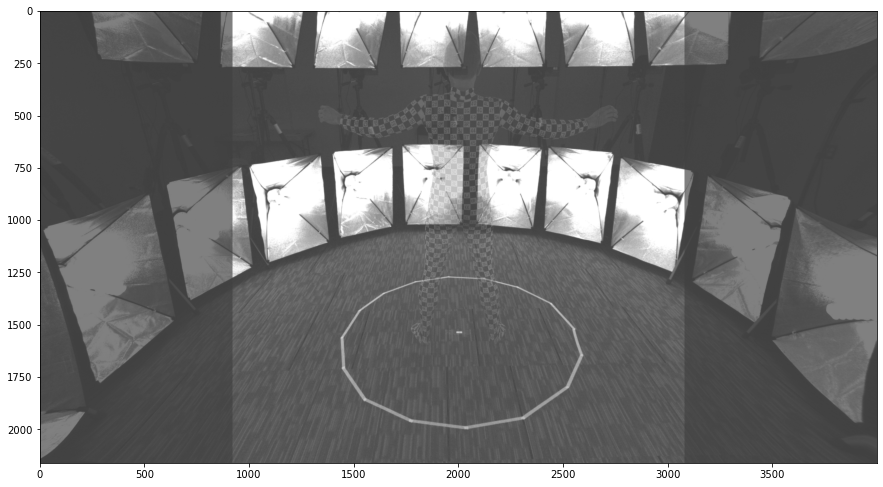

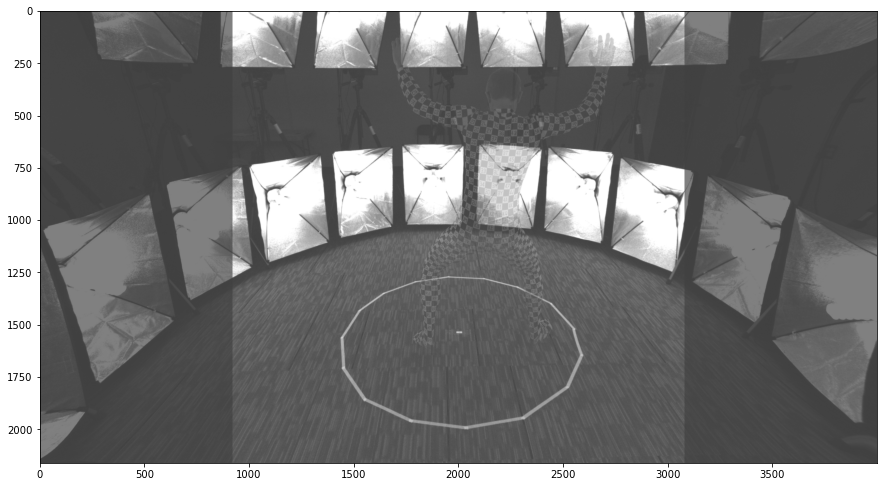

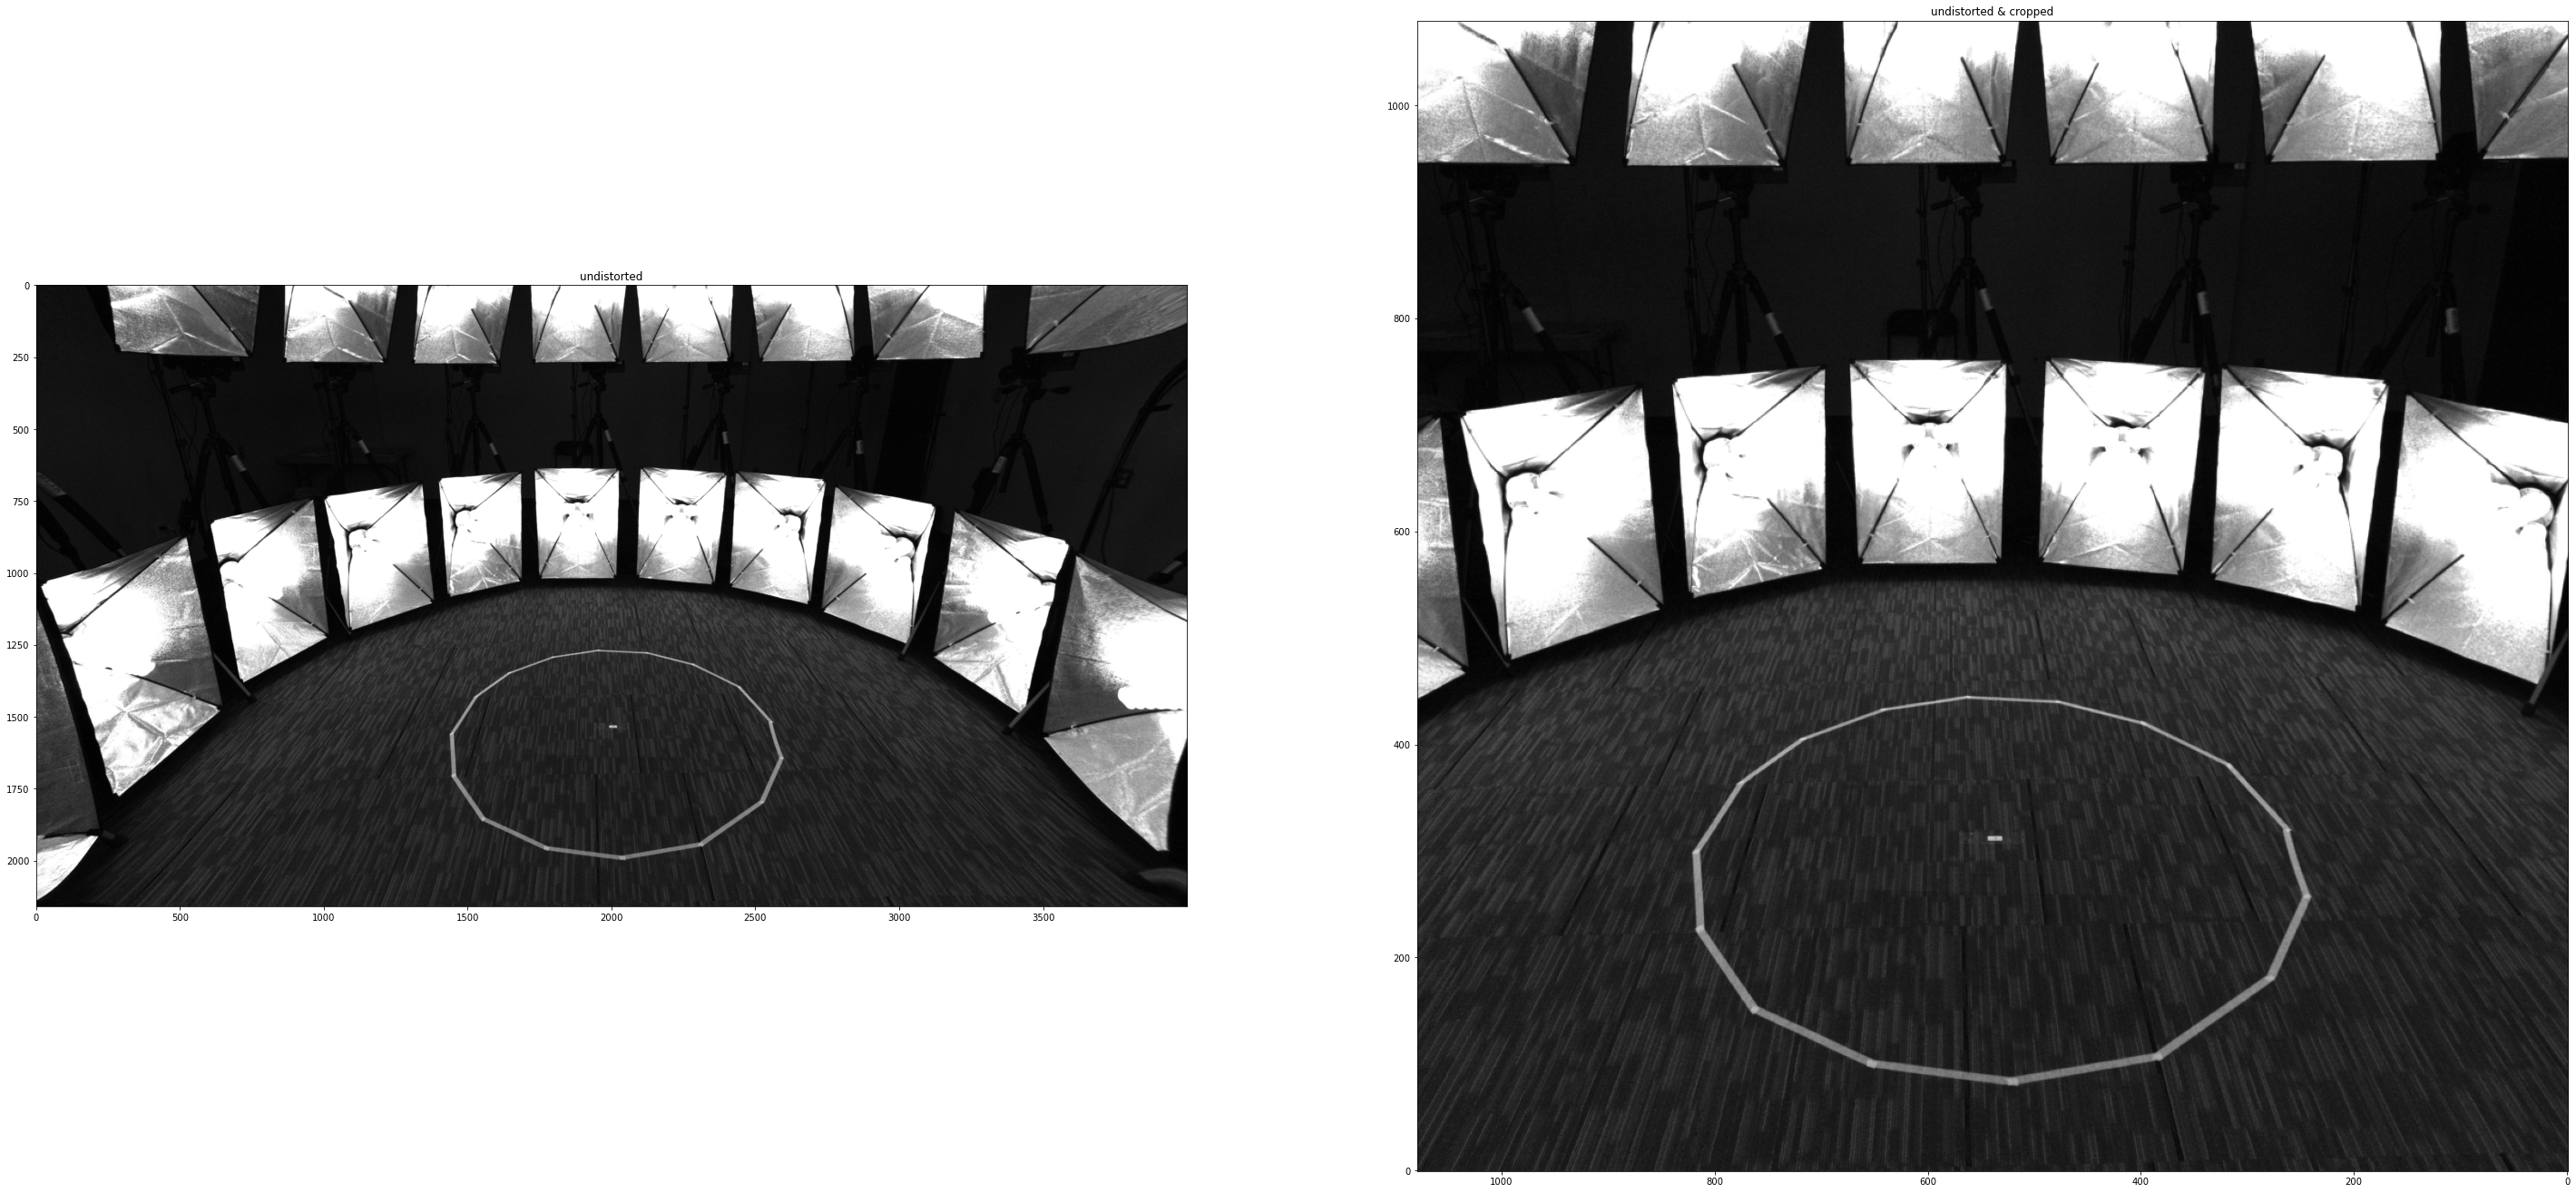

In [8]:
%matplotlib inline
img_name = '03052'
cam_idx = 0
img1 = img_refs_undistorted[img_name][cam_idx]
img2 = img_refs[img_name][cam_idx]
print('Image original =========')
print(' ', img1.shape, ',', np.max(img1), ',', img1.dtype)
print('   {:,.2f} Mb'.format(img1.nbytes * 0.000001))
print('Image cropped =========')
print(' ', img2.shape, ',', np.max(img2), ',', img2.dtype)
print('   {:,.2f} Mb'.format(img2.size * img2.itemsize * 0.000001))
print()

# overlay ref image & cropped ref image
for img_name in img_names:
    for i in range(16):
        # target image
        img1 = img_refs_undistorted[img_name][i]
        img2 = np.zeros((img1.shape[0], img1.shape[1]))
        cx = img2.shape[0] // 2
        cy = img2.shape[1] // 2
        imgref = cv2.flip(cv2.resize(img_refs[img_name][i], (img1.shape[0], img1.shape[0])), -1)
        w = imgref.shape[0] // 2
        h = imgref.shape[0] // 2 
        img2[cx-w:cx+w,cy-h:cy+h] = imgref
        
        cp = cv2.flip(cv2.resize(clean_plates[i], (img1.shape[0], img1.shape[0])), -1)
        img2[cx-w:cx+w,cy-h:cy+h] = cp
        
        plt.figure(figsize=(15, 15))
        plt.imshow(img1, cmap='gray', alpha=0.5)
        plt.imshow(img2, cmap='gray', alpha=0.5)
        break

for i in range(16):
    # clean plates
    img1 = clean_plates_undistort[i]
    img2 = clean_plates[i]
    fig, ax = plt.subplots(1, 2, figsize=(50, 50))
    ax[0].imshow(img1, cmap='gray')
    ax[0].set_title('undistorted')
    ax[1].imshow(img2, cmap='gray')
    ax[1].set_title('undistorted & cropped')
    ax[1].invert_yaxis()
    ax[1].invert_xaxis()
    plt.show()
    break

# Model

self.dnormals: torch.Size([6750, 1]) , nverts: torch.Size([6750, 3])
texture_map: 4.19==4.19 Mb
  torch.Size([1, 1024, 1024, 1]) 4.19Mb torch.float32 1.0
ref image: torch.Size([1080, 1080, 1]), 4.67 Mb


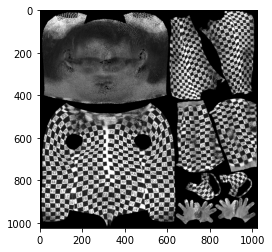

In [9]:
model = None
torch.cuda.empty_cache()
batch_size = 1
n_batch = n_forwards // batch_size
texturemap_path = './14c_data/output/texturemap_averaged.npy'
# texturemap_path = None
model = Model_normal(device, texturemap_path=texturemap_path, texturemap_shape=texturemap_shape, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)
texture_maps = model.texture_map
print('texture_map: {:,.2f}=={:,.2f} Mb'.format(texture_maps.element_size() * texture_maps.nelement() * 0.000001, texture_maps.detach().cpu().numpy().nbytes*0.000001))
texture_maps_np = texture_maps.detach().cpu().numpy()
print('  {} {:,.2f}Mb {} {}'.format(texture_maps.shape, texture_maps_np.nbytes*0.000001, texture_maps.dtype, np.max(texture_maps_np)))
img_name = list(model.image_refs.keys())[0]
img = model.image_refs[img_name][0]
print('ref image: {}, {:,.2f} Mb'.format(img.shape, img.element_size() * img.nelement() * 0.000001))
plt.imshow(texture_maps_np.squeeze(), cmap='gray', vmin=0, vmax=1)

### test run

In [10]:
torch.cuda.empty_cache()
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=model.image_size, 
    blur_radius=0.0,
    faces_per_pixel=2, 
    bin_size = 0, # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)

model.deform_meshes()
# model.set_mesh_texturemap()
images_with_bg = np.empty((n_batch*batch_size, model.image_size, model.image_size, 1))
images = np.empty((n_batch*batch_size, model.image_size, model.image_size, 4))
images_target = np.empty((n_batch*batch_size, model.image_size, model.image_size, 1))
losses = []
print('{} renders ({} images, {} cams), n_batch={}, batch_size={}'.format(n_forwards, len(img_names), len(cams), n_batch, batch_size))
for batch_idx in range(n_batch):
    print(batch_idx)
    i0 = batch_idx*batch_size
    i1 = i0 + batch_size
    
    imgs, l, l_dict = model(batch_idx, learn_texturemap=False, learn_deform=False, raster_settings=raster_settings, blend_params=blend_params)
    losses.append(l.detach().cpu().data)

    images_with_bg[i0:i1] = imgs['currents_with_bg'].detach().cpu().numpy()
    images[i0:i1] = imgs['currents'].detach().cpu().numpy()
    images_target[i0:i1] = imgs['targets'].detach().cpu().numpy()
    # model.save_parameters('./7_data/output/deform_verts.npy')
    # model.export_obj('./7_data/output/obj.obj')
    break

32 renders (2 images, 16 cams), n_batch=32, batch_size=1
0


In [ ]:
for img_idx in range(len(img_names)):
    for cam_idx in range(len(cams)):
        i = img_idx*len(cams) + cam_idx
        fig, ax = plt.subplots(1, 4, figsize=(30, 10))
        ax = ax.ravel()
        img = cv2.flip(images[i], -1)
        ax[0].imshow(img[..., 3], cmap='gray')
        ax[0].set_title('{}. {}.pgm, cam[{}/{}]'.format(i, img_names[img_idx], cam_idx+1, len(cams)))
        ax[0].set_xlabel('{}, [{}, {}]'.format(img.shape, np.min(img), np.max(img)))
        
        img = cv2.flip(images[i][..., :3], -1)
        ax[1].imshow(img, cmap='gray')
        ax[1].set_xlabel('{}, [{}, {}]'.format(img.shape, np.min(img), np.max(img)))
        
        img2 = cv2.flip(images_target[i], -1)
        ax[2].imshow(img2, cmap='gray')
        ax[2].set_xlabel('{}, [{}, {}]'.format(img2.shape, np.min(img2), np.max(img2)))
        
        diff = np.abs(img2 - img[..., 0])
        ax[3].imshow(diff)
        
        plt.show()
        break
    print()


# reprojection check

In [ ]:
mesh_points = {}

t0 = time.time()
for i in range(len(model.meshes)):
    mesh_vertices = model.meshes[i].verts_packed().cpu()
    
    pts = []
    for cam_idx in range(16):
        params = cam_params[cam_idx]
        p = reproject(params, mesh_vertices, distort=False)
        pts.append(p)
    
    img_name = img_names[i]
    mesh_points[img_name] = pts
t1 = time.time()
print('{:.2f}s'.format(t1-t0))
print(len(mesh_points))
del mesh_vertices, pts

In [ ]:
for k, v in mesh_points.items():
    print(k, ':', len(v), 'cameras,', v[0].shape, 'points/camera')

In [ ]:
%matplotlib inline

bd = model.batch_dict
mesh_idx = bd['mesh_idx']

for mesh_idx, img_name in enumerate(list(mesh_points.keys())):
    print(img_name)
    
    for cam_idx in range(model.n_cams):
        i = mesh_idx*model.n_cams + cam_idx
        
        plt.figure(figsize=(10, 10))
        
        # bg
        img_bg = img_refs[img_name][cam_idx]
        img_bg = cv2.flip(img_bg, -1)
        plt.imshow(img_bg, alpha=0.5, cmap='gray')

        # mesh from pytorch3d
        img_mesh = images[i]
        img_mesh = cv2.flip(img_mesh, -1)
        plt.imshow(img_mesh, alpha=0.5, cmap='gray')

        pts = mesh_points[img_name][cam_idx]
        pts_small_x = (pts[:, 0] - (4000-2160)*0.5) * image_size/2160
        pts_small_y = pts[:, 1] * image_size/2160
        pts_small = np.stack([pts_small_x, pts_small_y]).T
        pts_center = np.mean(pts_small, axis=0)
        plt.scatter(pts_small[:, 0], pts_small[:, 1], c='b', s=0.1)
        plt.title('Camera {}'.format(i))

        # plot centers
        plt.scatter(pts_center[0], pts_center[1], c='r')

        if i == 0:
            print('reference image:', np.max(img_bg), img_bg.dtype, img_bg.shape)
            print('rendered pytorch image :', np.max(img_mesh), img_mesh.dtype, img_mesh.shape, ', {:,.2f} Mb'.format(img_mesh.nbytes * 0.000001), np.max(img_mesh))
        plt.show()
        break

# before training

### test plot

In [10]:
def plot_dverts(out_dir, e, batch_idx, lr, img_name, cam_idx, loss_dict, grads, image_curr, image_target, img_sil=None):
    fig, ax = plt.subplots(1, 6, figsize=(30, 6), tight_layout=True)
    plt.suptitle('Epoch {} | {}.pgm | lr={}'.format(e, img_name, lr), fontsize=16)
    a_loss = ax[0]
    a_grad = ax[1]
    a_curr = ax[2]
    a_target = ax[3]
    a_overlay = ax[4]
    a_diff = ax[5]
    
    legend_str = ['total']
    losses = loss_dict['total']
    a_loss.plot(losses, linewidth=3)
    a_loss.set_title('losses: {}'.format(losses[-1]))
    for k, l in loss_dict.items():
        if k != 'total':
            a_loss.plot(l)
            legend_str.append(k)
    a_loss.legend(legend_str)
    a_loss.grid()
    
    a_grad.set_title('||grad||: {}'.format(grads[-1]))
    a_grad.plot(grads)
    a_grad.grid()
    
    a_curr.imshow(image_curr, cmap='gray', vmin=0, vmax=1.0)
    a_curr.set_title('current | camera {}'.format(cam_idx))
    a_curr.set_xlabel('{}'.format(image_curr.shape))
    
    a_target.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
    if img_sil is not None:
        a_target.imshow(img_sil, alpha=0.25)
    a_target.set_title('target')
    a_target.set_xlabel('{}'.format(image_target.shape))
    
    a_overlay.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
    a_overlay.imshow(image_curr, alpha=0.5, cmap='gray', vmin=0, vmax=1.0)
    a_overlay.set_title('overlay')
    
    diff = image_curr - image_target
    diff_abs = np.abs(diff)
    a_diff.imshow(diff_abs)
    a_diff.set_title('difference')
    a_diff.set_xlabel('{}, min={:.2f}, max={:.2f}'.format(diff.shape, np.min(diff), np.max(diff)))
    
    out_path = out_dir + '/plot_{}.png'.format(e)
    plt.savefig(out_path, dpi=300)
    plt.close()
    
    plot_img = imageio.imread(out_path)
    return plot_img

def plot_dverts_initial_final_2x2(out_dir, i, N, img_name, cam_idx, image_target, image_curr1, image_curr2, image_sil1, image_sil2):
    fig, ax = plt.subplots(2, 2, figsize=(12, 13), tight_layout=True)
    plt.suptitle('[{}/{}] {}.pgm'.format(i+1, N, e, img_name), fontsize=16)

    for c in range(2):
        if c == 0:
            prefix_str = '[Initial]'
            image_curr = image_curr1
            image_sil = image_sil1
        else:
            prefix_str = '[Final]'
            image_curr = image_curr2
            image_sil = image_sil2
            
        a_target = ax[0, c]
        a_overlay = ax[1, c]

        a_target.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
        if img_sil is not None:
            a_target.imshow(img_sil, alpha=0.25)
        a_target.set_title('{} target'.format(prefix_str))
        a_target.set_xlabel('{}'.format(image_target.shape))

        a_overlay.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
        a_overlay.imshow(image_curr, alpha=0.5, cmap='gray', vmin=0, vmax=1.0)
        a_overlay.set_title('{} overlay'.format(prefix_str))

    out_path = out_dir + '/plot_final_{}.png'.format(i)
    plt.savefig(out_path, dpi=300)
    plt.close()
    
    plot_img = imageio.imread(out_path)
    return plot_img

def plot_dverts_initial_final(out_dir, i, N, img_name, cam_idx, image_target, image_curr1, image_curr2, image_sil1, image_sil2):
    fig, ax = plt.subplots(2, 4, figsize=(24, 13), tight_layout=True)
    plt.suptitle('[{}/{}] {}.pgm'.format(i+1, N, e, img_name), fontsize=16)

    for r in range(2):
        if r == 0:
            prefix_str = 'initial'
            image_curr = image_curr1
            image_sil = image_sil1
        else:
            prefix_str = 'final'
            image_curr = image_curr2
            image_sil = image_sil2
            
        a_curr = ax[r, 0]
        a_target = ax[r, 1]
        a_overlay = ax[r, 2]
        a_diff = ax[r, 3]

        a_curr.imshow(image_curr, cmap='gray', vmin=0, vmax=1.0)
        a_curr.set_title('{} current | camera {}'.format(prefix_str, cam_idx))
        a_curr.set_xlabel('{}'.format(image_curr.shape))

        a_target.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
        if image_sil is not None:
            a_target.imshow(image_sil, alpha=0.25)
        a_target.set_title('{} target'.format(prefix_str))
        a_target.set_xlabel('{}'.format(image_target.shape))

        a_overlay.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
        a_overlay.imshow(image_curr, alpha=0.5, cmap='gray', vmin=0, vmax=1.0)
        a_overlay.set_title('{} overlay'.format(prefix_str))

        diff = image_curr - image_target
        diff_abs = np.abs(diff)
        a_diff.imshow(diff_abs)
        a_diff.set_title('{} difference'.format(prefix_str))
        a_diff.set_xlabel('{}, min={:.2f}, max={:.2f}'.format(diff.shape, np.min(diff), np.max(diff)))

    out_path = out_dir + '/plot_final_{}.png'.format(i)
    plt.savefig(out_path, dpi=300)
    plt.close()
    
    plot_img = imageio.imread(out_path)
    return plot_img

def plot_3_dverts(out_dir, prefix_str, i, N, img_name, cam_idx, image_target, image_curr, image_sil):
    fig, ax = plt.subplots(1, 2, figsize=(20, 11), tight_layout=True)
    plt.suptitle('[{}/{}] {}.pgm'.format(i+1, N, img_name), fontsize=16)

    a_target = ax[0]
    a_overlay = ax[1]

    a_target.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
    if image_sil is not None:
        a_target.imshow(image_sil, alpha=0.25)
    a_target.set_title('{} target'.format(prefix_str))
    a_target.set_xlabel('{}'.format(image_target.shape))

    a_overlay.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
    a_overlay.imshow(image_curr, alpha=0.5, cmap='gray', vmin=0, vmax=1.0)
    a_overlay.set_title('{} overlay'.format(prefix_str))

    out_path = out_dir + '/compare_{}_{}.png'.format(i, prefix_str)
    plt.savefig(out_path, dpi=300)
    plt.close()
    
    plot_img = imageio.imread(out_path)
    return plot_img

def plot_6(out_dir, e, batch_idx, lr, img_name, cam_idx, loss_dict, grads, image_curr, image_target, texturemap, img_sil=None):
    fig, ax = plt.subplots(1, 6, figsize=(30, 6), tight_layout=True)
    plt.suptitle('Epoch {} | {}.pgm | lr={}'.format(e, img_name, lr), fontsize=16)
    a_loss = ax[0]
    a_grad = ax[1]
    a_curr = ax[2]
    a_target = ax[3]
    a_diff = ax[4]
    a_tex = ax[5]
    
    legend_str = ['total']
    losses = loss_dict['total']
    a_loss.plot(losses)
    a_loss.set_title('losses: {}'.format(losses[-1]))
    for k, l in loss_dict.keys():
        if k != 'total':
            a_loss.plot(l)
            legend_str.append(k)
    a_loss.legend(legend_str)
    a_loss.grid()
    
    a_grad.set_title('||grad||: {}'.format(grads[-1]))
    a_grad.plot(grads)
    a_grad.grid()
    
    a_curr.imshow(image_curr, cmap='gray', vmin=0, vmax=1.0)
    a_curr.set_title('current | camera {}'.format(cam_idx))
    a_curr.set_xlabel('{}'.format(image_curr.shape))
    
    a_target.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
    if img_sil is not None:
        a_target.imshow(img_sil, alpha=0.25)
    a_target.set_title('target')
    a_target.set_xlabel('{}'.format(image_target.shape))
    
    diff = image_curr - image_target
    diff_abs = np.abs(diff)
    a_diff.imshow(diff_abs)
    a_diff.set_title('difference')
    a_diff.set_xlabel('{}, min={:.2f}, max={:.2f}'.format(diff.shape, np.min(diff), np.max(diff)))
    
    a_tex.imshow(np.clip(texturemap, a_min=0, a_max=1.0), cmap='gray', vmin=0, vmax=1.0)
    a_tex.set_title('texturemap')
    a_tex.set_xlabel('{}, min={:.2f}, max={:.2f}'.format(texturemap.shape, np.min(texturemap), np.max(texturemap)))
    
    out_path = out_dir + '/plot_{}.png'.format(e)
    plt.savefig(out_path, dpi=300)
    plt.close()
    
    plot_img = imageio.imread(out_path)
    return plot_img


def plot_3(out_dir, i, N, img_name, cam_idx, image_curr, image_target):
    fig, ax = plt.subplots(1, 3, figsize=(18, 7), tight_layout=True)
    plt.suptitle('[{}/{}] {}.pgm'.format(i+1, N, e, img_name), fontsize=16)
    a_curr = ax[0]
    a_target = ax[1]
    a_diff = ax[2]
    
    a_curr.imshow(image_curr, cmap='gray', vmin=0, vmax=1.0)
    a_curr.set_title('current | camera {}'.format(cam_idx))
    a_curr.set_xlabel('{}'.format(image_curr.shape))
    
    a_target.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
    a_target.set_title('target')
    a_target.set_xlabel('{}'.format(image_target.shape))
    
    diff = image_curr - image_target
    diff_abs = np.abs(diff)
    a_diff.imshow(diff_abs)
    a_diff.set_title('difference')
    a_diff.set_xlabel('{}, min={:.2f}, max={:.2f}'.format(diff.shape, np.min(diff), np.max(diff)))
    
    out_path = out_dir + '/plot_final_{}.png'.format(i)
    plt.savefig(out_path, dpi=300)
    plt.close()
    
    plot_img = imageio.imread(out_path)
    return plot_img

### test forward, backward & plot

torch.Size([1, 1024, 1024, 1]) torch.float32 tensor(0.) tensor(1.)
(1024, 1024) float32 0.0 1.0


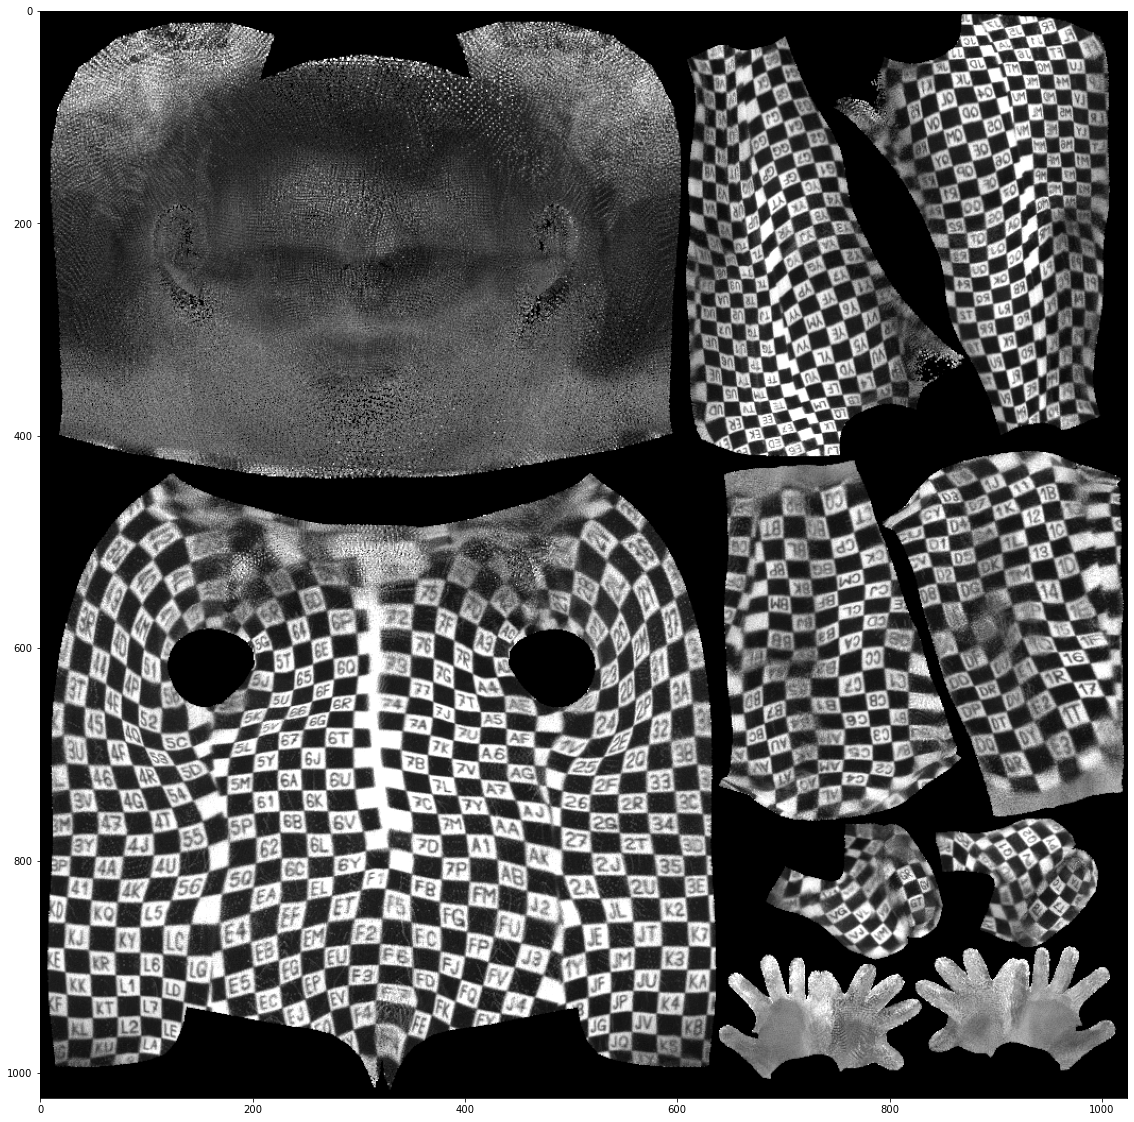

In [12]:
texturemap_path = r'D:\1_Projects\200325_PyTorch3d_Toy\14b_data\output_1\texturemap_averaged.npy'
# texturemap_path = r'D:\1_Projects\200325_PyTorch3d_Toy\9_data\output\200413_SingleVsMulti\multi_L1\texturemap_learned.png'
if texturemap_path is not None:
    if '.png' in texturemap_path:
        texturemap = imageio.imread(texturemap_path) / 255.0
        print(texturemap.shape)
    elif '.npy' in texturemap_path:
        texturemap = np.load(texturemap_path).astype(np.float32)
    texture_map_torch = torch.from_numpy(texturemap).unsqueeze(0).unsqueeze(-1).float()
else:
    texture_map_torch = torch.from_numpy(np.ones((1, texturemap_shape[0], texturemap_shape[1], 1)).astype(np.float32))
print(texture_map_torch.shape, texture_map_torch.dtype, torch.min(texture_map_torch), torch.max(texture_map_torch))

texture_map = texture_map_torch.detach().squeeze().cpu().numpy()
print(texture_map.shape, texture_map.dtype, np.min(texture_map), np.max(texture_map))
plt.figure(figsize=(20, 20))
plt.imshow(texture_map, cmap='gray')
plt.show()

self.dnormals: torch.Size([6750, 1]) , nverts: torch.Size([6750, 3])
----- torch.cuda.empty_cache() -----
torch.cuda.memory_allocated(): 381.88 Mb
torch.cuda.memory_cached(): 413.14 Mb
32 renders (2 images, 16 cams), n_batch=16, batch_size=2
run: 0.54s, plot: 3.35s


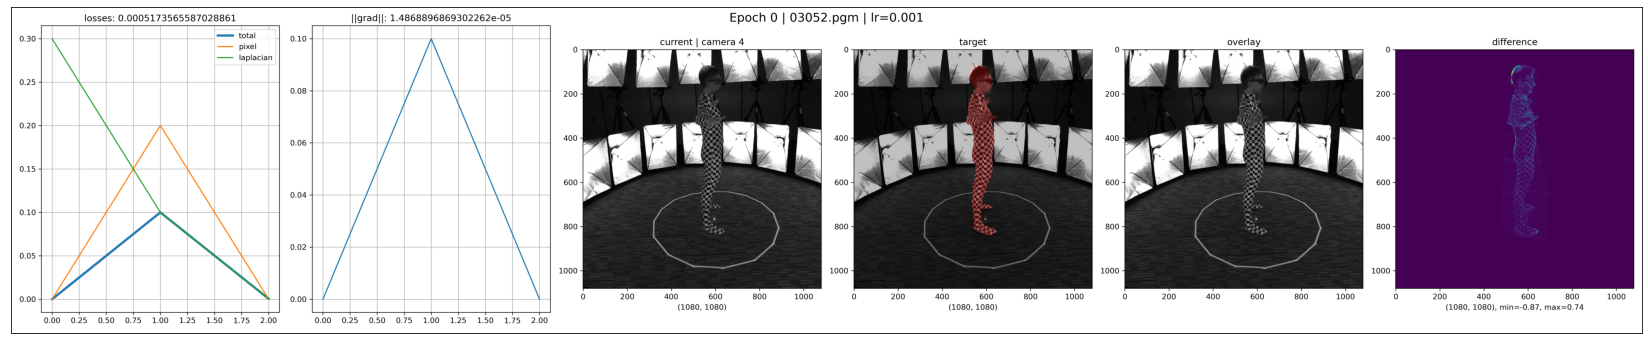

In [12]:
# =================================================================================== #
batch_size = 2
n_batch = n_forwards // batch_size
texturemap_path = './14c_data/output/texturemap_averaged.npy'
# texturemap_path = r'D:\1_Projects\200325_PyTorch3d_Toy\9_data\output\200413_SingleVsMulti\multi_L1\texturemap_learned.png'
model = Model_normal(device, texturemap_path=texturemap_path, texturemap_shape=texturemap_shape, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)

print('----- torch.cuda.empty_cache() -----')
torch.cuda.empty_cache()
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))
# =================================================================================== #

out_dir = './16b_data/output'
vt_path = mesh_dir + '/mesh_deformed_{}.obj'.format(img_names[0])
lr = 1.0
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=model.image_size, 
    blur_radius=0,
    faces_per_pixel=1, 
    bin_size = 0, # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)

model.deform_meshes()

print('{} renders ({} images, {} cams), n_batch={}, batch_size={}'.format(n_forwards, len(img_names), len(cams), n_batch, batch_size))
plot_idx = 0
e = 0
losses = {'total': [0, 0.1], 'pixel': [0, 0.2], 'laplacian': [0.3, 0.1]}
grad_norms = [0, 0.1]
for batch_idx in range(2, n_batch):
    t0 = time.time()
    i0 = batch_idx*batch_size
    i1 = i0 + batch_size
    img_name = model.batch_dict['img_name'][i0:i1][plot_idx]
    cam_idx = model.batch_dict['cam_idx'][i0:i1][plot_idx]
    
    # ================== #
    # train
    # ================== #
    optimizer.zero_grad()
    imgs, l, l_dict = model(batch_idx, learn_texturemap=False, learn_deform=True, raster_settings=raster_settings, blend_params=blend_params)
    l.backward()
    optimizer.step()
    
#     model.export_obj(out_dir, vt_path=vt_path, fname_suffix='')
    
    img_sil = cv2.flip(imgs['currents'][plot_idx][..., 3].detach().squeeze().cpu().numpy(), -1)
    img_sil = np.dstack([np.where(img_sil > 0, 1, 0), np.zeros(img_sil.shape), np.zeros(img_sil.shape)])
    img_curr = cv2.flip(imgs['currents_with_bg'][plot_idx].detach().squeeze().cpu().numpy(), -1)
    img_target = cv2.flip(imgs['targets'][plot_idx].detach().squeeze().cpu().numpy(), -1)
    
    losses['total'].append(l_dict['total'].detach().cpu().numpy())
    losses['pixel'].append(l_dict['pixel'].detach().cpu().numpy())
    losses['laplacian'].append(l_dict['laplacian'].detach().cpu().numpy())
    grad_value = model.dnormals.grad.detach().cpu().numpy()
    grad_norms.append(np.linalg.norm(grad_value))
    texturemap = model.texture_map.clone().detach().squeeze().cpu().numpy()
    
    t1 = time.time()
    plot_img = plot_dverts(out_dir, e, batch_idx, 0.001, img_name, cam_idx, losses, grad_norms, img_curr, img_target, img_sil)
    plt.figure(figsize=(30, 6))
    plt.imshow(plot_img)
    plt.xticks([]), plt.yticks([])
    t2 = time.time()
    print('run: {:.2f}s, plot: {:.2f}s'.format(t1-t0, t2-t1))
    
    plt.show()
    break


# === Train ===

In [13]:
def get_settings_str():
    log_str = ''
    
    log_str += '{:<15}: {}\n'.format('cameras', cam_path)
    log_str += '{:<15}: {}\n'.format('mesh', mesh_dir)
    log_str += '{:<15}: {}\n'.format('clean plates', clean_plate_dir)
    log_str += '{:<15}:'.format('images')
    for img_name in img_names:
        log_str += ' {}.pgm'.format(img_name)
    log_str += '\n'
    log_str += '---------------------------------------------\n\n'
    return log_str

### initial renderings

self.dnormals: torch.Size([6750, 1]) , nverts: torch.Size([6750, 3])
----- torch.cuda.empty_cache() -----
torch.cuda.memory_allocated(): 381.88 Mb
torch.cuda.memory_cached(): 463.47 Mb
 1/16 2/16 3/16 4/16 5/16 6/16 7/16 8/16 9/16 10/16 11/16 12/16 13/16 14/16 15/16 16/16
Done


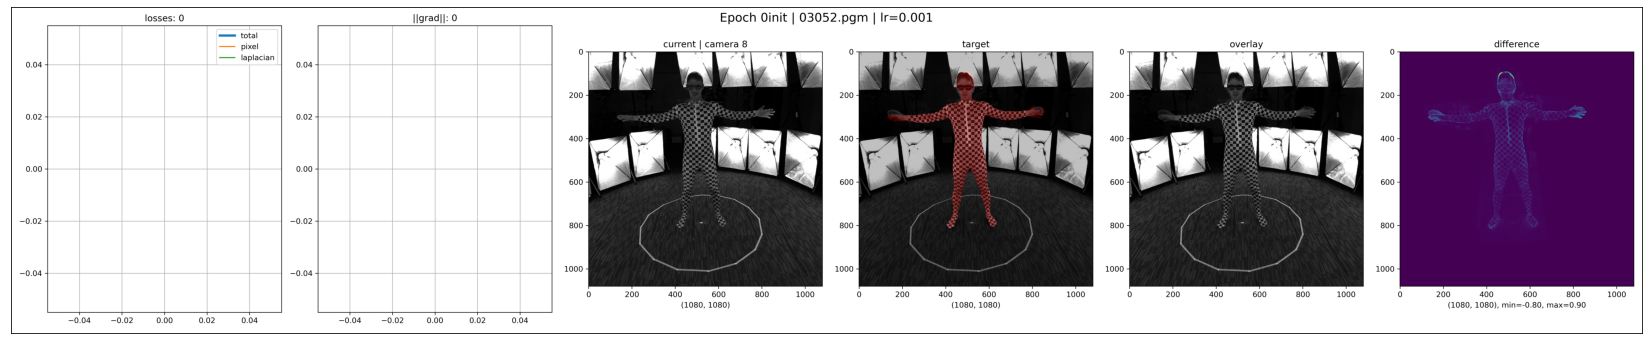

In [14]:
images_alpha_initial = np.empty((model.n_batch*model.batch_size, model.image_size, model.image_size))
images_initial = np.empty((model.n_batch*model.batch_size, model.image_size, model.image_size))
targets = np.empty((model.n_batch*model.batch_size, model.image_size, model.image_size))

# =================================================================================== #
batch_size = 2
n_batch = n_forwards // batch_size
texturemap_path = './14c_data/output/texturemap_averaged.npy'
model = Model_normal(device, texturemap_path=texturemap_path, texturemap_shape=texturemap_shape, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=model.image_size, 
    blur_radius=0,
    faces_per_pixel=1, 
    bin_size = 0, # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)

print('----- torch.cuda.empty_cache() -----')
torch.cuda.empty_cache()
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))
# =================================================================================== #

model.deform_meshes()
for batch_idx in range(model.n_batch):
    print(' {}/{}'.format(batch_idx+1, model.n_batch), end='')
    i0 = batch_idx*model.batch_size
    i1 = i0 + model.batch_size
    imgs, l, l_dict = model(batch_idx, learn_texturemap=False, learn_deform=False, raster_settings=raster_settings, blend_params=blend_params)

    images_initial[i0:i1] = imgs['currents_with_bg'].squeeze().detach().cpu().numpy()
    targets[i0:i1] = imgs['targets'].squeeze().detach().cpu().numpy()
    images_alpha_initial[i0:i1] = imgs['currents'][..., 3].squeeze().detach().cpu().numpy()
print('\nDone')

out_idx = 8
out_dir = './16b_data/output'
img_name = model.batch_dict['img_name'][out_idx]
cam_idx = model.batch_dict['cam_idx'][out_idx]
img_curr = cv2.flip(images_initial[out_idx], -1)
img_sil = cv2.flip(images_alpha_initial[out_idx], -1)
img_sil = np.dstack([np.where(img_sil > 0, 1, 0), np.zeros(img_sil.shape), np.zeros(img_sil.shape)])
img_target = cv2.flip(targets[out_idx], -1)

plot_img = plot_dverts(out_dir, '0init', batch_idx, 0.001, img_name, cam_idx, {'total': [0], 'pixel': [0], 'laplacian': [0]}, [0], img_curr, img_target, img_sil)
plt.figure(figsize=(30, 6))
plt.imshow(plot_img)
plt.xticks([]), plt.yticks([])
plt.show()

self.dnormals: torch.Size([6750, 1]) , nverts: torch.Size([6750, 3])
----- torch.cuda.empty_cache() -----
torch.cuda.memory_allocated(): 1,338.00 Mb
torch.cuda.memory_cached(): 1,715.47 Mb
Log output: ./16b_data/output/log_20200512.txt


<ipython-input-15-b0b0a286dbad>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(1000000000))


Epoch     4: reducing learning rate of group 0 to 4.5000e-01.
Epoch     7: reducing learning rate of group 0 to 4.0500e-01.
Epoch    10: reducing learning rate of group 0 to 3.6450e-01.
Epoch    13: reducing learning rate of group 0 to 3.2805e-01.
Epoch    16: reducing learning rate of group 0 to 2.9525e-01.


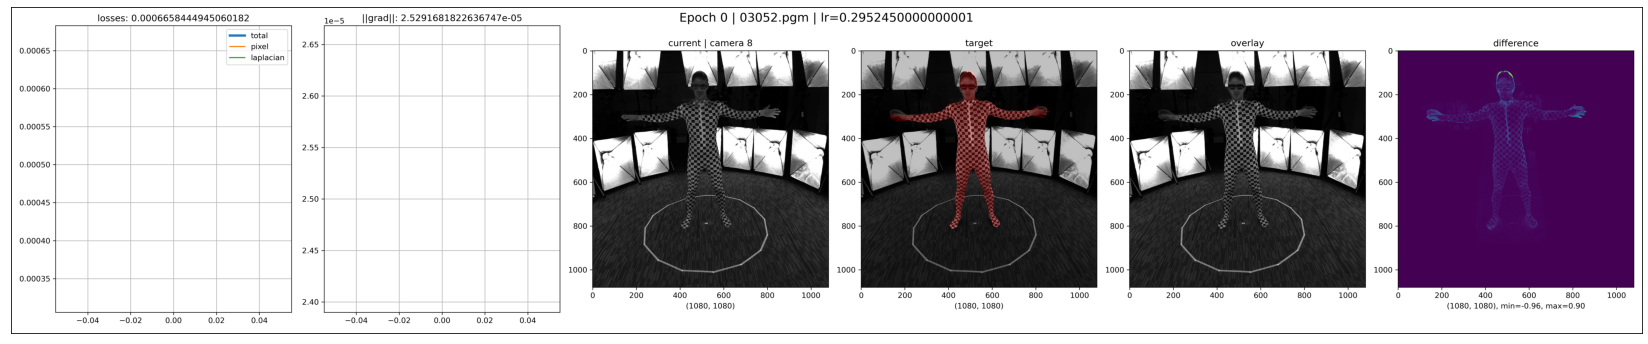

Epoch    19: reducing learning rate of group 0 to 2.6572e-01.
Epoch    22: reducing learning rate of group 0 to 2.3915e-01.
Epoch    25: reducing learning rate of group 0 to 2.1523e-01.
Epoch    28: reducing learning rate of group 0 to 1.9371e-01.
Epoch    31: reducing learning rate of group 0 to 1.7434e-01.
Epoch    34: reducing learning rate of group 0 to 1.5691e-01.
Epoch    37: reducing learning rate of group 0 to 1.4121e-01.
Epoch    40: reducing learning rate of group 0 to 1.2709e-01.
Epoch    43: reducing learning rate of group 0 to 1.1438e-01.
Epoch    46: reducing learning rate of group 0 to 1.0295e-01.
Epoch    49: reducing learning rate of group 0 to 9.2651e-02.
Epoch    52: reducing learning rate of group 0 to 8.3386e-02.
Epoch    55: reducing learning rate of group 0 to 7.5047e-02.
Epoch    58: reducing learning rate of group 0 to 6.7543e-02.
Epoch    61: reducing learning rate of group 0 to 6.0788e-02.
Epoch    64: reducing learning rate of group 0 to 5.4709e-02.
Epoch   

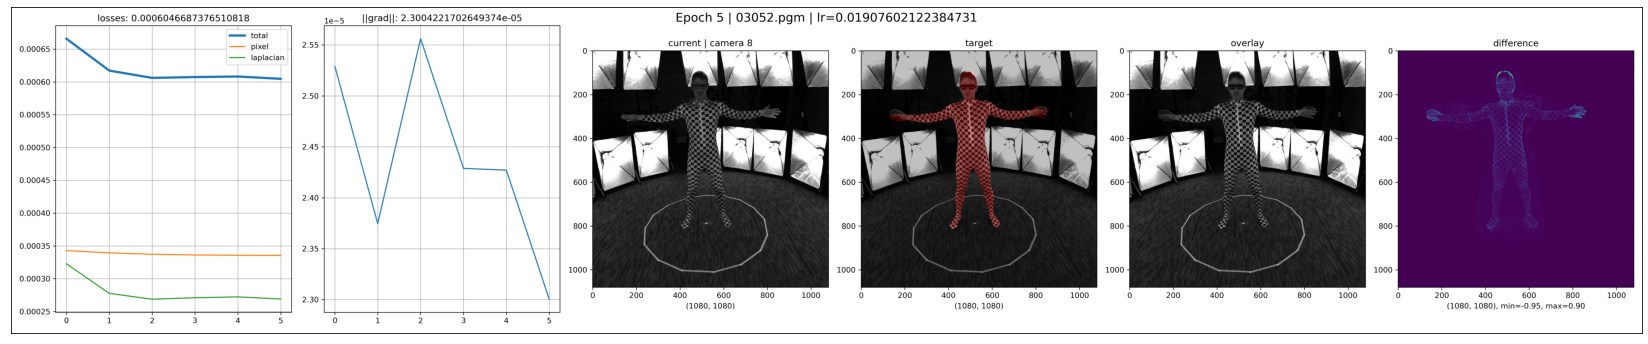

Epoch    97: reducing learning rate of group 0 to 1.7168e-02.
Epoch   100: reducing learning rate of group 0 to 1.5452e-02.
Epoch   103: reducing learning rate of group 0 to 1.3906e-02.
Epoch   106: reducing learning rate of group 0 to 1.2516e-02.
Epoch   109: reducing learning rate of group 0 to 1.1264e-02.
Epoch   112: reducing learning rate of group 0 to 1.0138e-02.
Epoch   115: reducing learning rate of group 0 to 9.1240e-03.
Epoch   118: reducing learning rate of group 0 to 8.2116e-03.
Epoch   121: reducing learning rate of group 0 to 7.3904e-03.
Epoch   124: reducing learning rate of group 0 to 6.6514e-03.
Epoch   127: reducing learning rate of group 0 to 5.9863e-03.
Epoch   130: reducing learning rate of group 0 to 5.3876e-03.
Epoch   133: reducing learning rate of group 0 to 4.8489e-03.
Epoch   136: reducing learning rate of group 0 to 4.3640e-03.
Epoch   139: reducing learning rate of group 0 to 3.9276e-03.
Epoch   142: reducing learning rate of group 0 to 3.5348e-03.
Epoch   

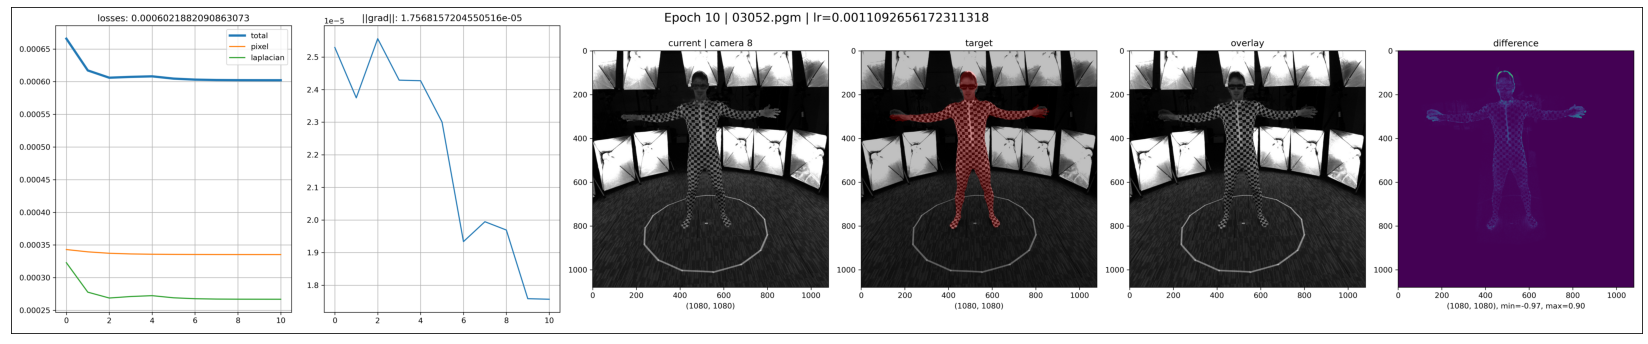

Epoch   178: reducing learning rate of group 0 to 9.9834e-04.
Epoch   181: reducing learning rate of group 0 to 8.9851e-04.
Epoch   184: reducing learning rate of group 0 to 8.0865e-04.
Epoch   187: reducing learning rate of group 0 to 7.2779e-04.
Epoch   190: reducing learning rate of group 0 to 6.5501e-04.
Epoch   193: reducing learning rate of group 0 to 5.8951e-04.
Epoch   196: reducing learning rate of group 0 to 5.3056e-04.
Epoch   199: reducing learning rate of group 0 to 4.7750e-04.
Epoch   202: reducing learning rate of group 0 to 4.2975e-04.
Epoch   205: reducing learning rate of group 0 to 3.8678e-04.
Epoch   208: reducing learning rate of group 0 to 3.4810e-04.
Epoch   211: reducing learning rate of group 0 to 3.1329e-04.
Epoch   214: reducing learning rate of group 0 to 2.8196e-04.
Epoch   217: reducing learning rate of group 0 to 2.5376e-04.
Epoch   220: reducing learning rate of group 0 to 2.2839e-04.
Epoch   223: reducing learning rate of group 0 to 2.0555e-04.
Epoch   

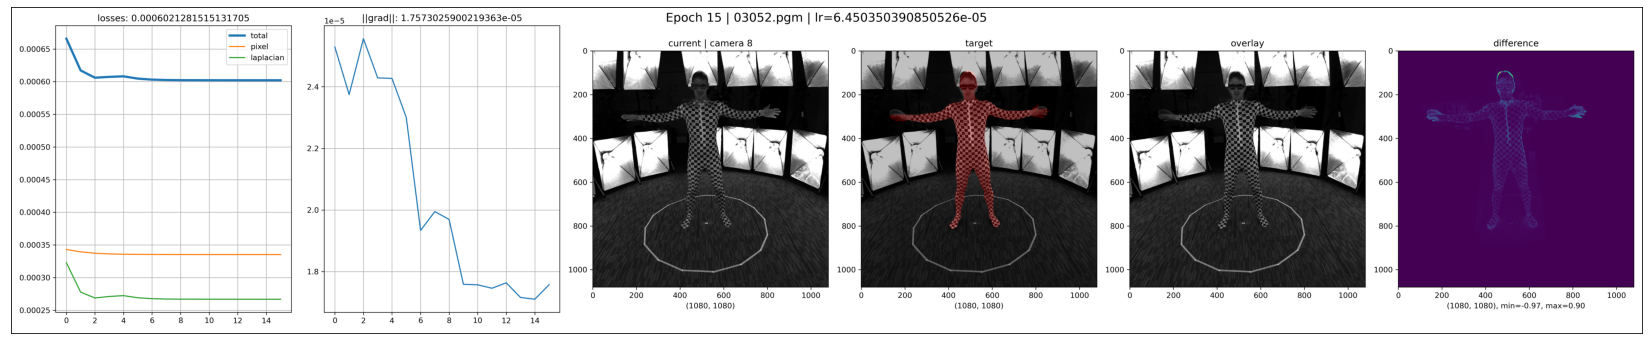

lr=6.450350390850526e-05. BREAK
[1/2] Obj exported to: ./16b_data/output/mesh_deformed_0.obj
[2/2] Obj exported to: ./16b_data/output/mesh_deformed_1.obj


In [15]:
# =================================================================================== #
model = Model_normal(device, texturemap_path=texturemap_path, texturemap_shape=texturemap_shape, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)
print('----- torch.cuda.empty_cache() -----')
torch.cuda.empty_cache()
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))
# =================================================================================== #
vt_path = mesh_dir + '/mesh_deformed_{}.obj'.format(img_names[0])

now = datetime.now()
date_str = '{}{:>02}{:>02}'.format(now.year, now.month, now.day)
log_path = out_dir + '/log_{}.txt'.format(date_str)
__output_log(log_path, '=== {} Start ==========================\n'.format(date_str))
__output_log(log_path, get_settings_str())

print('Log output: {}'.format(log_path))
loop = tqdm_notebook(range(1000000000))
loop.set_description('start')

lr = 0.5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)

losses = {'total': [], 'pixel': [], 'laplacian': []}
grads = []

images_final = None
images_alpha_final = None
for e in loop:
    t0 = time.time()
    
    images_alpha = np.empty((model.n_batch*model.batch_size, model.image_size, model.image_size))
    images = np.empty((model.n_batch*model.batch_size, model.image_size, model.image_size))
    
    save_plot = (e % 5 == 0)
    losses_minibatch = {'total': 0.0, 'pixel': 0.0, 'laplacian': 0.0}
    grad_norm_mean = 0.0
    for batch_idx in range(model.n_batch):
        i0 = batch_idx*model.batch_size
        i1 = i0 + model.batch_size
        
        model.deform_meshes()
        
        # ================== #
        # train
        # ================== #
        optimizer.zero_grad()
        imgs, l, l_dict = model(batch_idx, learn_texturemap=False, learn_deform=True, raster_settings=raster_settings, blend_params=blend_params)
        l.backward()
        optimizer.step()
        
        images[i0:i1] = imgs['currents_with_bg'].squeeze().detach().cpu().numpy()
        images_alpha[i0:i1] = imgs['currents'][..., 3].squeeze().detach().cpu().numpy()
        
        for k, v in l_dict.items():
            losses_minibatch[k] += (v.detach().cpu().numpy() / model.n_batch)
        
        scheduler.step(losses_minibatch['pixel'])
        grad_value = model.dnormals.grad.detach().cpu().numpy()
        grad_norm_mean += (np.linalg.norm(grad_value) / model.n_batch)
        lr_curr = optimizer.param_groups[0]['lr']
        loop.set_description('[{}] batch[{}/{}] lr={:.4f}, loss={:.6f}\n'.format(e, batch_idx+1, model.n_batch, lr_curr, losses_minibatch['total']))

    grads.append(grad_norm_mean)
    for k, v in losses_minibatch.items():
        losses[k].append(v)

    t1 = time.time()
    # log
    mb_alloc = torch.cuda.memory_allocated() * 0.000001
    mb_cached = torch.cuda.memory_cached() * 0.000001
    now = datetime.now()
    hour = str(now.hour)
    minute = str(now.minute)
    second = str(now.second)
    now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
    out_str = '{} | {:04} | {:.2f}s | lr={:.8f} | loss={:.6f} | GPU_allocated({:,.2f}Mb) | GPU_cached({:,.2f}Mb)\n'.format(now_str, e, t1-t0, lr_curr, losses_minibatch['total'], mb_alloc, mb_cached)
    __output_log(log_path, out_str)

    images_final = images.copy()
    images_alpha_final = images_alpha.copy()
    
    if save_plot:
        out_idx = 8
        texturemap = model.texture_map.clone().squeeze().detach().cpu().numpy()
        img_name = model.batch_dict['img_name'][out_idx]
        cam_idx = model.batch_dict['cam_idx'][out_idx]
        img_curr = cv2.flip(images_final[out_idx], -1)
        img_sil = cv2.flip(images_alpha_final[out_idx], -1)
        img_sil = np.dstack([np.where(img_sil > 0, 1, 0), np.zeros(img_sil.shape), np.zeros(img_sil.shape)])
        img_target = cv2.flip(targets[out_idx], -1)
        plot_img = plot_dverts(out_dir, e, batch_idx, lr_curr, img_name, cam_idx, losses, grads, img_curr, img_target, img_sil)
        
        plt.figure(figsize=(30, 6))
        plt.imshow(plot_img)
        plt.xticks([]), plt.yticks([])
        plt.show()

        # save texturemap
#         texels_np = model.texture_map.clone().detach().cpu().numpy()
#         np.save(out_dir + '/texturemap.npy', texels_np)
#         del texels_np

#         texturemap_out = (255.0*np.clip(model.texture_map.detach().squeeze().cpu().numpy(), a_min=0, a_max=1.0)).astype(np.uint8)
#         im = Image.fromarray(texturemap_out)
#         im.save(out_dir + '/texturemap_learned.png', dpi=(600, 600))
    if lr_curr < 1e-10 or e >= 15:
        print('lr={}. BREAK'.format(lr_curr))
        model.export_obj(out_dir, vt_path=vt_path, export_texturemap=(e == 0), fname_suffix='')
        break

### export objs

In [ ]:
model.export_obj(out_dir, vt_path=vt_path, export_texturemap=(e == 0), fname_suffix='')


### render comparisons

  1/32(11.90s)  2/32(11.94s)  3/32(12.05s)  4/32(11.85s)  5/32(11.70s)  6/32(11.71s)  7/32(11.82s)  8/32(11.98s)  9/32(11.68s)  10/32(11.75s)  11/32(11.87s)  12/32(11.70s)  13/32(11.77s)  14/32(11.96s)  15/32(11.87s)  16/32(11.87s)  17/32(11.93s)  18/32(11.91s)  19/32(11.88s)  20/32(11.94s)  21/32(11.75s)  22/32(11.88s)  23/32(11.88s)  24/32(12.01s)  25/32(11.77s)  26/32(11.79s)  27/32(11.95s)  28/32(11.61s)  29/32(11.64s)  30/32(11.94s)  31/32(11.76s)  32/32(11.81s)
Done: 378.86s


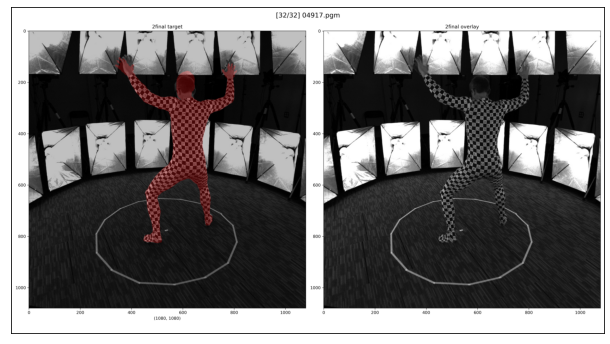

In [16]:
tstart = time.time()
for i in range(len(images_final)):
    t0 = time.time()
    image_curr1 = cv2.flip(images_initial[i].squeeze(), -1)
    img_sil1 = cv2.flip(images_alpha_initial[i], -1)
    img_sil1 = np.dstack([np.where(img_sil1 > 0, 1, 0), np.zeros(img_sil1.shape), np.zeros(img_sil1.shape)])

    image_curr2 = cv2.flip(images_final[i].squeeze(), -1)
    img_sil2 = cv2.flip(images_alpha_final[i], -1)
    img_sil2 = np.dstack([np.where(img_sil2 > 0, 1, 0), np.zeros(img_sil2.shape), np.zeros(img_sil2.shape)])

    image_target = cv2.flip(targets[i].squeeze(), -1)

    cam_idx = model.batch_dict['cam_idx'][i]
    img_name = model.batch_dict['img_name'][i]
    _ = plot_3_dverts(out_dir, '1initial', i, len(images), img_name, cam_idx, image_target, image_curr1, img_sil1)
    plot_img = plot_3_dverts(out_dir, '2final', i, len(images), img_name, cam_idx, image_target, image_curr2, img_sil2)
    t1 = time.time()
    print('  {}/{}({:.2f}s)'.format(i+1, len(images_final), t1-t0), end='')
print('\nDone: {:.2f}s'.format(time.time()-tstart))
plt.figure(figsize=(18, 6))
plt.imshow(plot_img)
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
model.export_obj(out_dir, vt_path=vt_path, export_texturemap=(e == 0), fname_suffix='')


#### merge two sets of images for comparisons

In [126]:
from shutil import copyfile

dir1 = out_dir + '/3_sigma_compare/1e-3_numface=1'
dir2 = out_dir + '/3_sigma_compare/1e-4_numface=1'

new_dir = out_dir + '/3_sigma_compare/compare'

images1 = glob.glob(dir1 + '/*final.png')
for i, src in enumerate(images1):
    dst = new_dir + '/{}a.png'.format(i)
    copyfile(src, dst)
    print(src ,'->', dst)
print()
images2 = glob.glob(dir2 + '/*final.png')
for i, src in enumerate(images2):
    dst = new_dir + '/{}b.png'.format(i)
    copyfile(src, dst)
    print(src ,'->', dst)
print('Done')

./16_data/output/3_sigma_compare/1e-3_numface=1\compare_0_2final.png -> ./16_data/output/3_sigma_compare/compare/0a.png
./16_data/output/3_sigma_compare/1e-3_numface=1\compare_10_2final.png -> ./16_data/output/3_sigma_compare/compare/1a.png
./16_data/output/3_sigma_compare/1e-3_numface=1\compare_11_2final.png -> ./16_data/output/3_sigma_compare/compare/2a.png
./16_data/output/3_sigma_compare/1e-3_numface=1\compare_12_2final.png -> ./16_data/output/3_sigma_compare/compare/3a.png
./16_data/output/3_sigma_compare/1e-3_numface=1\compare_13_2final.png -> ./16_data/output/3_sigma_compare/compare/4a.png
./16_data/output/3_sigma_compare/1e-3_numface=1\compare_14_2final.png -> ./16_data/output/3_sigma_compare/compare/5a.png
./16_data/output/3_sigma_compare/1e-3_numface=1\compare_15_2final.png -> ./16_data/output/3_sigma_compare/compare/6a.png
./16_data/output/3_sigma_compare/1e-3_numface=1\compare_16_2final.png -> ./16_data/output/3_sigma_compare/compare/7a.png
./16_data/output/3_sigma_compare/